<a href="https://colab.research.google.com/github/2303A51856/NLP/blob/main/Lab_8_NLP_1856.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:

!pip install nltk gensim scikit-learn matplotlib pandas --quiet

import re
import nltk
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from gensim.models import Word2Vec
from nltk.tag import hmm


nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [21]:

df = pd.read_csv("/content/tweets.csv")

print("Dataset Loaded Successfully!")
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nSample Data:")
print(df.head())


if 'text' in df.columns:
    tweets_raw = df['text'].astype(str).tolist()
else:

    text_col = df.columns[0]
    print(f"⚠️ Using '{text_col}' as text column (adjust if wrong)")
    tweets_raw = df[text_col].astype(str).tolist()


Dataset Loaded Successfully!
Shape: (11370, 5)

Columns: ['id', 'keyword', 'location', 'text', 'target']

Sample Data:
   id keyword        location  \
0   0  ablaze             NaN   
1   1  ablaze             NaN   
2   2  ablaze   New York City   
3   3  ablaze  Morgantown, WV   
4   4  ablaze             NaN   

                                                text  target  
0  Communal violence in Bhainsa, Telangana. "Ston...       1  
1  Telangana: Section 144 has been imposed in Bha...       1  
2  Arsonist sets cars ablaze at dealership https:...       1  
3  Arsonist sets cars ablaze at dealership https:...       1  
4  "Lord Jesus, your love brings freedom and pard...       0  


In [22]:

url_re = re.compile(r'https?://\S+|www\.\S+')
mention_re = re.compile(r'@\w+')
hashtag_re = re.compile(r'#\w+')
non_alphanum = re.compile(r'[^0-9a-zA-Z\s]')

def preprocess(text):
    text = text.lower()
    text = url_re.sub('', text)
    text = mention_re.sub('', text)
    text = hashtag_re.sub('', text)
    text = non_alphanum.sub(' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

tweets = [preprocess(t) for t in tweets_raw]

print("Preprocessing complete! Showing sample cleaned tweets:")
for t in tweets[:5]:
    print("-", t)


Preprocessing complete! Showing sample cleaned tweets:
- communal violence in bhainsa telangana stones were pelted on muslims houses and some houses and vehicles were set ablaze
- telangana section 144 has been imposed in bhainsa from january 13 to 15 after clash erupted between two groups on january 12 po
- arsonist sets cars ablaze at dealership
- arsonist sets cars ablaze at dealership
- lord jesus your love brings freedom and pardon fill me with your holy spirit and set my heart ablaze with your l


In [23]:

tokenized = [nltk.word_tokenize(t) for t in tweets[:200]]
tagged_bootstrap = [nltk.pos_tag(sent, tagset='universal') for sent in tokenized]

trainer = hmm.HiddenMarkovModelTrainer()
hmm_tagger = trainer.train_supervised(tagged_bootstrap[:-5])

print("\n POS Tagging Example Outputs:\n")
for sent in tokenized[-5:]:
    tagged = hmm_tagger.tag(sent)
    print("Tweet:", " ".join(sent))
    print("Tags :", tagged)
    print("-"*60)



 POS Tagging Example Outputs:

Tweet: the untamed boys singing love siren from my ambulance
Tags : [('the', 'DET'), ('untamed', 'ADJ'), ('boys', 'ADJ'), ('singing', 'ADJ'), ('love', 'ADJ'), ('siren', 'ADJ'), ('from', 'ADJ'), ('my', 'ADJ'), ('ambulance', 'ADJ')]
------------------------------------------------------------
Tweet: or pulling over for an ambulance
Tags : [('or', 'CONJ'), ('pulling', 'ADJ'), ('over', 'ADJ'), ('for', 'ADJ'), ('an', 'ADJ'), ('ambulance', 'ADJ')]
------------------------------------------------------------
Tweet: i hope there s going to be an ambulance waiting at the bottom because there s no way that fat lump can cli
Tags : [('i', 'NOUN'), ('hope', 'NOUN'), ('there', 'DET'), ('s', 'NOUN'), ('going', 'VERB'), ('to', 'PRT'), ('be', 'VERB'), ('an', 'DET'), ('ambulance', 'NOUN'), ('waiting', 'ADJ'), ('at', 'ADJ'), ('the', 'ADJ'), ('bottom', 'ADJ'), ('because', 'ADJ'), ('there', 'ADJ'), ('s', 'ADJ'), ('no', 'ADJ'), ('way', 'ADJ'), ('that', 'ADJ'), ('fat', 'ADJ'),

/usr/local/lib/python3.12/dist-packages/nltk/tag/hmm.py:333: RuntimeWarning: overflow encountered in cast
  X[i, j] = self._transitions[si].logprob(self._states[j])
/usr/local/lib/python3.12/dist-packages/nltk/tag/hmm.py:335: RuntimeWarning: overflow encountered in cast
  O[i, k] = self._output_logprob(si, self._symbols[k])
/usr/local/lib/python3.12/dist-packages/nltk/tag/hmm.py:331: RuntimeWarning: overflow encountered in cast
  P[i] = self._priors.logprob(si)
/usr/local/lib/python3.12/dist-packages/nltk/tag/hmm.py:363: RuntimeWarning: overflow encountered in cast
  O[i, k] = self._output_logprob(si, self._symbols[k])


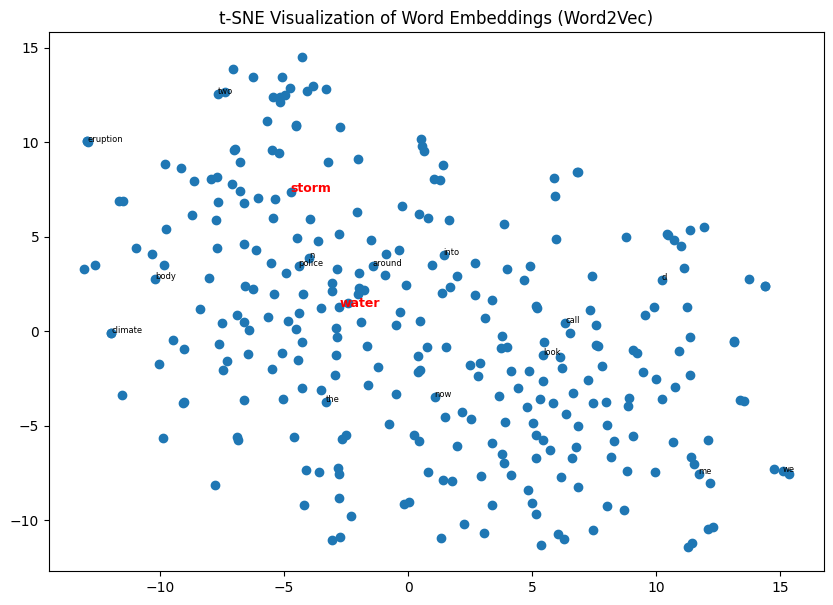

In [25]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tokenized_all = [nltk.word_tokenize(t) for t in tweets if len(t) > 0]
model = Word2Vec(sentences=tokenized_all, vector_size=100, window=5, min_count=2, workers=4, epochs=20)

vocab = list(model.wv.index_to_key)[:300]
vecs = [model.wv[w] for w in vocab]

vecs_array = np.array(vecs)

tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca', learning_rate='auto')
coords = tsne.fit_transform(vecs_array)

plt.figure(figsize=(10,7))
plt.scatter(coords[:,0], coords[:,1])

group_a = ["water","food","shelter"]
group_b = ["flood","earthquake","storm"]

for i, w in enumerate(vocab):
    if w in group_a or w in group_b:
        plt.text(coords[i,0], coords[i,1], w, fontsize=9, fontweight='bold', color='red')
    elif i % 20 == 0:
        plt.text(coords[i,0], coords[i,1], w, fontsize=6)

plt.title("t-SNE Visualization of Word Embeddings (Word2Vec)")
plt.show()

In [26]:

def label_tweet_simple(t):
    keywords = ['need','help','urgent','require','rescue','trapped','evacuate']
    return 'relief_request' if any(k in t for k in keywords) else 'general_info'

labels = [label_tweet_simple(t) for t in tweets]

vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=2)
X = vectorizer.fit_transform(tweets)
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

model_nb = MultinomialNB()
model_nb.fit(X_train, y_train)
y_pred = model_nb.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.9395005276116778

Classification Report:
                 precision    recall  f1-score   support

  general_info       0.94      1.00      0.97      2661
relief_request       1.00      0.05      0.10       182

      accuracy                           0.94      2843
     macro avg       0.97      0.53      0.54      2843
  weighted avg       0.94      0.94      0.91      2843

Confusion Matrix:
 [[2661    0]
 [ 172   10]]
